# Practical work 4: Frequency filtering, color

### By: Youcef Benslimane, 28715654

In [1]:
import numpy as np
from numpy.fft import fft2,ifft2,fftshift,ifftshift
import matplotlib.pyplot as plt
from PIL import Image

def imshow(I,title=None,size=500):
    """ display an image with a specific size """
    plt.figure(figsize=(size//80,size//80))
    plt.gray()
    plt.imshow(I)
    if title: plt.title(title)
    plt.show()

In [2]:
def computeFT(I):
    """ Array -> Array[complex] """
    return fft2(I)

def toVisualizeFT(If):
    """ Array[complex] -> Array[float] """
    return np.abs(fftshift(If))

def toVisualizeLogFT(If):
    """ Array[complex] -> Array[float] """
    return np.log(1+np.abs(fftshift(If)))

def thresholdImage(I,s):
    """ Array*int -> Array """
    J = np.copy(I)
    J = np.where(J>=s,255,0)
    return J


## Exercice 1 - Frequency filtering

1. Compute than display the centered module of Fourier transform of `img/mandrill.png` (use functions seen in previous lessons). 

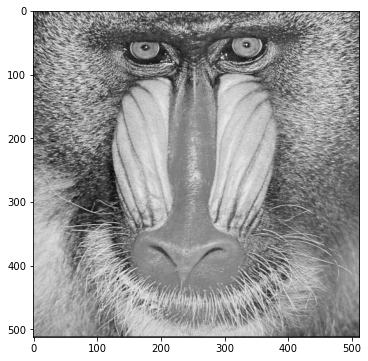

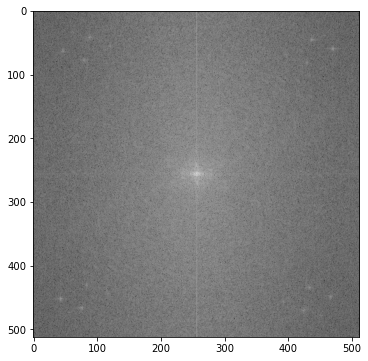

In [3]:
mandrill = np.array(Image.open('img/mandrill.png'))
img = mandrill.copy()
imgFT = computeFT(img)
imgFTMod = toVisualizeLogFT(imgFT)
imshow(img)
imshow(imgFTMod)


2. Write a function `idealLowPassFilter(n,m,fc)` returning an ideal low pass filter with frequency cutoff $f_c$ and size $n\times m$. Recall: this function set to 1 pixels at Euclidian distance $f_c$ from the center (null frequency).

In [4]:
def idealLowPassFilter(n,m,fc):
    # Initialize the filter
    lp_Filter = np.zeros((n,m)) 
    
    # Get the center indexes
    center_x = n/2
    center_y = m/2
    
    for x in range(n):
        for y in range(m):
            dist = np.floor(np.sqrt((x-center_x)**2 + (y-center_y)**2))
            #if the distance is lower than the frequency cutoff then unmask ALL
            # the points that are close to the center
            if  dist < fc:
                lp_Filter[x,y]=1
    return lp_Filter
    

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


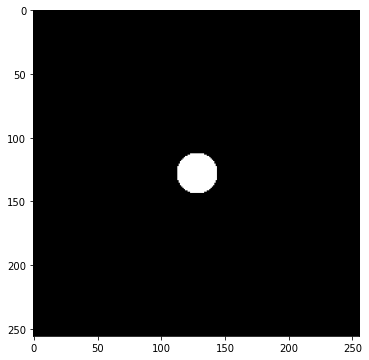

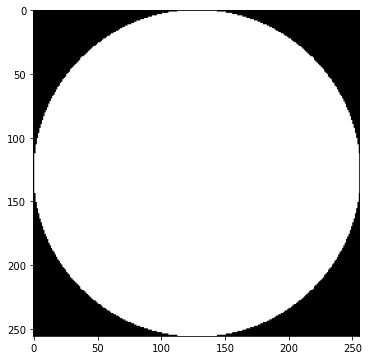

In [5]:
#test of the function idealLowPassFilter
lp_Filter = idealLowPassFilter(256,256,16)
print(lp_Filter)
imshow(lp_Filter)

lp_Filter2 = idealLowPassFilter(256,256,128)
imshow(lp_Filter2)

3. Write a function `lowPass(I,fc)` performing a low pass filtering of an image $I$. The function should
 - compute the centered Fourier transform of $I$
 - multiply point-by-point the spectrum with the ideal low filter produced by `idealLowPassFilter()`
 - uncenter the filtered spectrum and apply the inverse Fourier transform (function `ifft2()` from module `numpy.fft`
 - return the real part of filtered image

In [6]:
def lowPass(I,fc):
    img = I.copy()
    imgFT = computeFT(img)
    # compute the centered Fourier transform of img
    imgFT = fftshift(imgFT)
    n,m = imgFT.shape
    #multiply point-by-point the spectrum with the ideal low filter produced by idealLowPassFilter()
    imgFT_Filtered = imgFT * idealLowPassFilter(n,m,fc)
    #uncenter the filtered spectrum and apply the inverse Fourier transform (function ifft2() from module numpy.fft
    imgFT_Filtered = ifftshift(imgFT_Filtered)
    filtered_Img = ifft2(imgFT_Filtered)
    #return the real part of filtered image
    return np.abs(filtered_Img)

4. Experiment this function on `img/mandrill.png` and `img/lena.jpg` with various values of cut off $f_c$.
 - give two effects that appears when $f_c$ decreases,
 - propose two applications of this filtering.


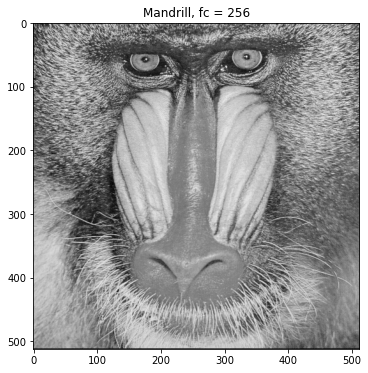

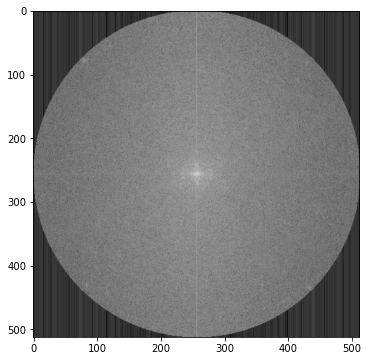

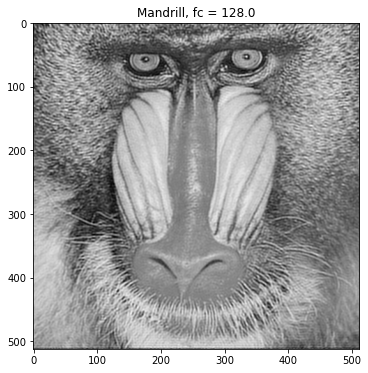

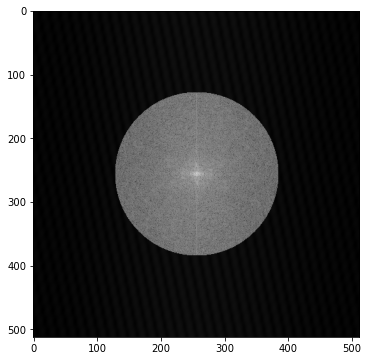

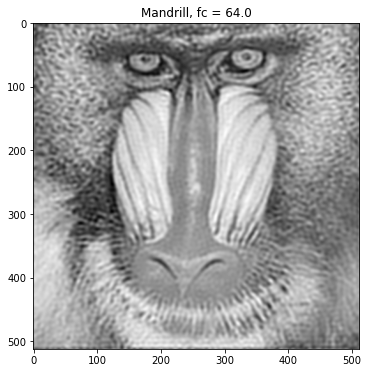

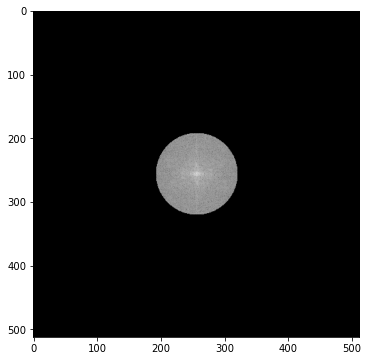

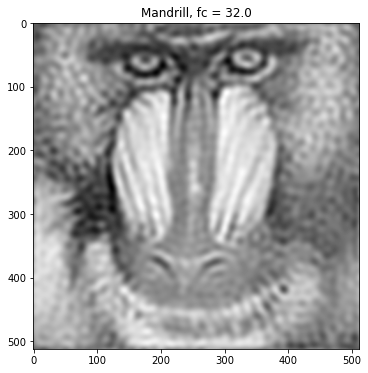

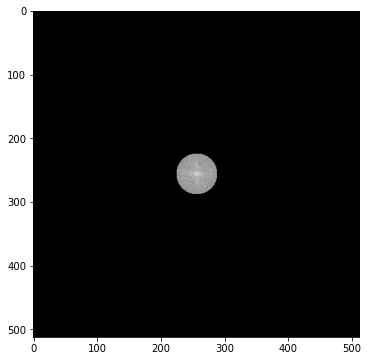

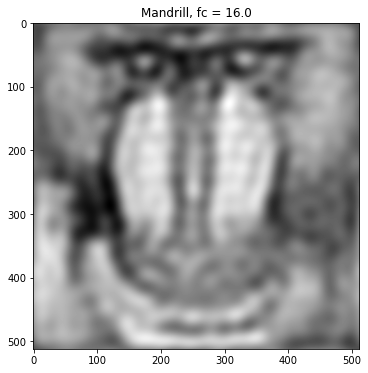

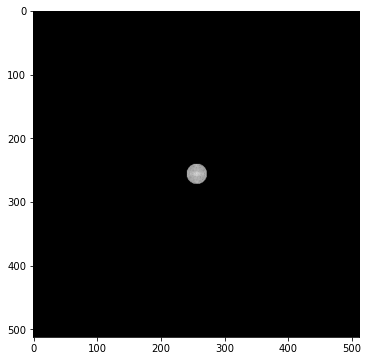

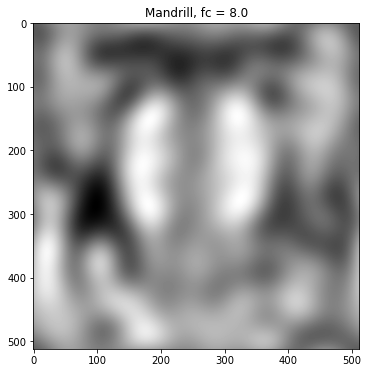

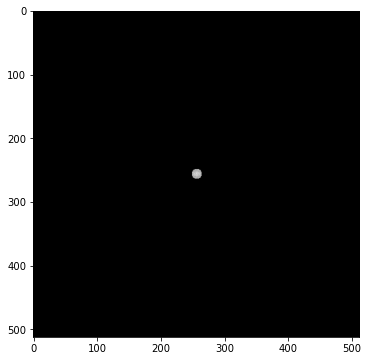

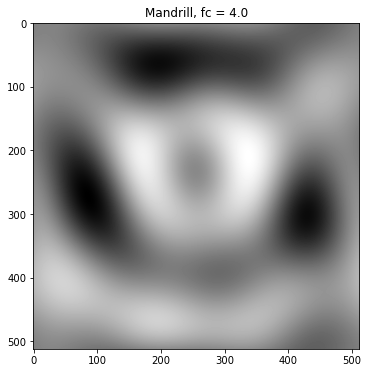

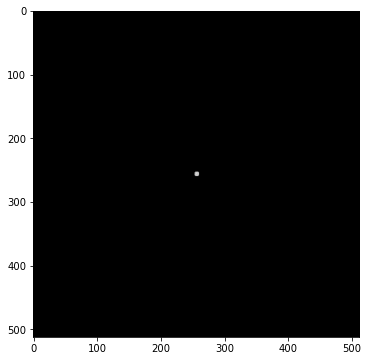

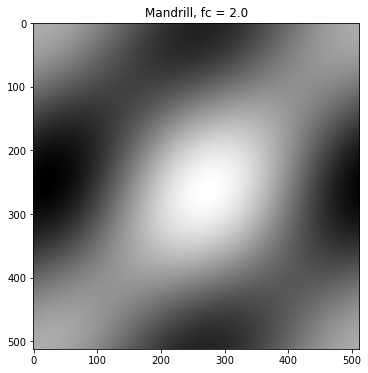

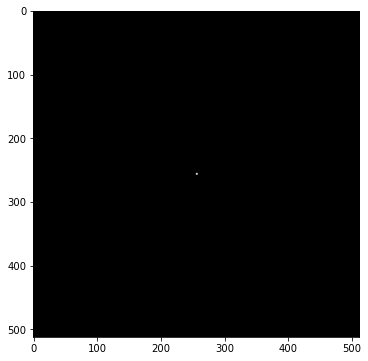

In [7]:
#Experimentations
#We're going to use various values of cut off fc
#And to be precise: 256, 128, 64, 32, 16, 8, 4, 2
i = 256
while i>=2:
    lp_Mandrill = lowPass(mandrill, i)
    lp_mandrill_FT = computeFT(lp_Mandrill) 
    mod = toVisualizeLogFT(lp_mandrill_FT)
    imshow(lp_Mandrill,'Mandrill, fc = ' + str(i))
    imshow(mod)
    i/=2



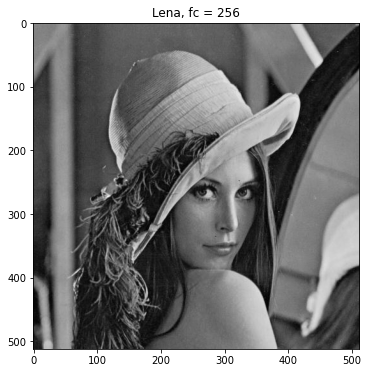

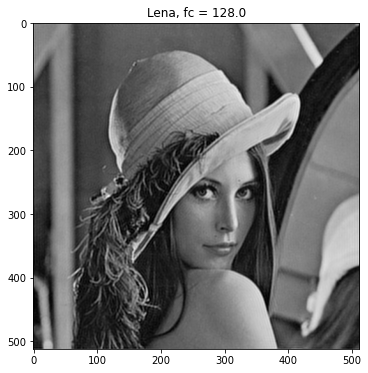

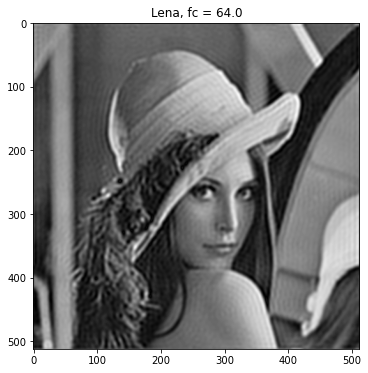

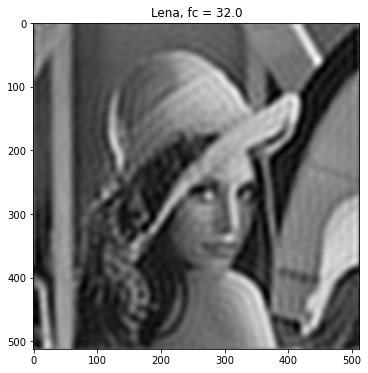

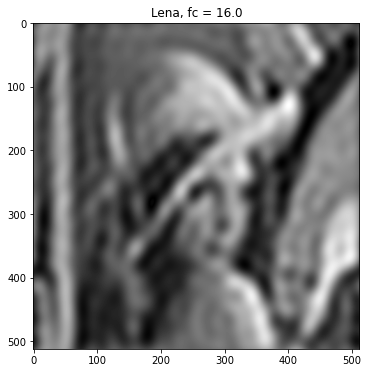

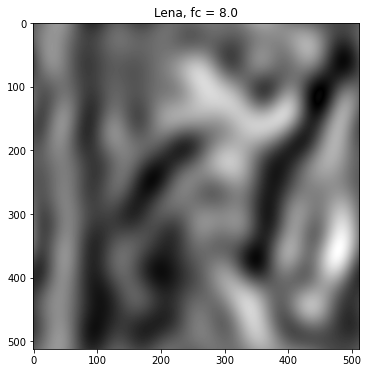

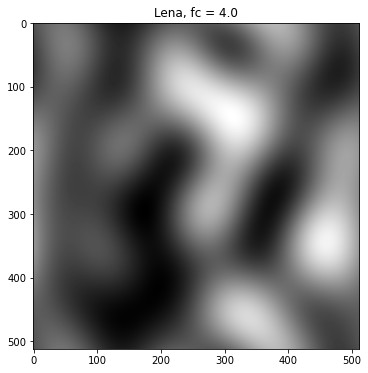

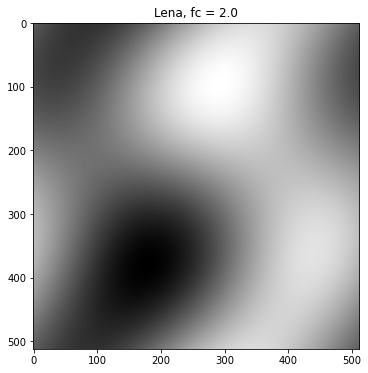

In [8]:
lena = np.array(Image.open('img/lena.jpg'))

i = 256
while i>=2:
    lp_Lena = lowPass(lena, i)
    imshow(lp_Lena,'Lena, fc = ' + str(i))
    i/=2



2 effects when fc decreases:

The first noticeable effect is the smoothing, as the fc decreases, the smoother the image becomes. It also becomes blurred.

The second effect is the loss of information. As the fc decreases, the image lose more details to the point where we cannot distinguish objects anymore.



2 Applications of filtering:

With filtering, we can use the "loss" of information for our benefit. For example, if we use a correct filter ( with the right cutoff) on images, we can make them lose insignificant details which will make object and pattern recognition easier for us.

We can also use filtering to make images look good. For example, we can use filters to make human skin seem smoother.

## Exercice 2 -  Linear filtering (convolution)

1. Given a kernel convolution of size $d\times d$, $d$ being odd. How many lines and columns should be added to each side of the image to apply this filter? The image is supposed surrounded by zero values.

To be able to treat the leftmost, rightmost, etc. rows and columns of an image, we will have to add some pixels on all four sides. These outskirts have to be of size d/2. (Indeed, the filter is a square structure of size d. It will be centered on pixel (x,y) at each step of the calculation, and on limit cases, e.g. on the rightmost column, half of it would exceed the image's borders.)

d being odd, we have to add a rounding method. We will hence add floor(d/2) lines and rows on each direction.

We will use zero-padding (that is, we will fill said lines with zeros) instead of mirroring, etc. to simplify the handling of this first basic case.


2. Write a function `imagePad(I,h)` getting an image and a kernel, returning a new image padded with zeros according to question 1. It is not allowed to use a module implementing the padding.

In [9]:
def imagePad(I,h):
    
    n = int((h.shape[0]-1)/2)
    px = I.shape[0] + 2*n
    py = I.shape[1] + 2*n
    
    padded = np.zeros((px,py))
    x,y=padded.shape
    
    padded[n:px-n,n: py-n]=I[:,:]
    
    return padded

In [10]:
#a function using pad module to compare
def imagePad2(I,h):
    I_Padded = I.copy()
    I_Padded = np.pad(I_Padded,int(h.shape[0]/2),'constant')
    return I_Padded

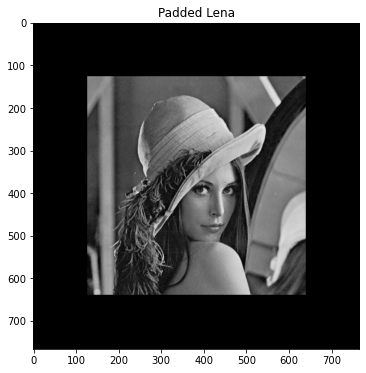

In [11]:
kernel = np.ones((256,256))
lena_Padded = imagePad(lena,kernel)
imshow(lena_Padded,"Padded Lena")

3. Write a function `conv2(I,h)` getting an image and a kernel and returning the convolution of $I$ by $h$. The function should return an image having the same shape than $I$. It is not allowed to use a module implementing the convolution.

In [12]:
def conv2(I,h):
    conv_I = np.zeros(I.shape)
    I_Padded = imagePad2(I,h)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            II = I_Padded[i:i+h.shape[0],j:j+h.shape[0]] 
            flippedFilter = np.flip(h,axis=0) 
            conv_I[i,j] = (II*flippedFilter ).sum() 
    return conv_I

4. Try this function on mean filter of size $3\times3$, $5\times 5$ and $7\times 7$. Discuss the results.

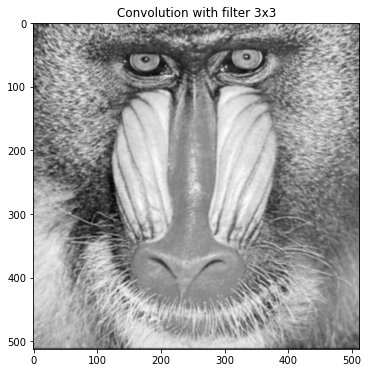

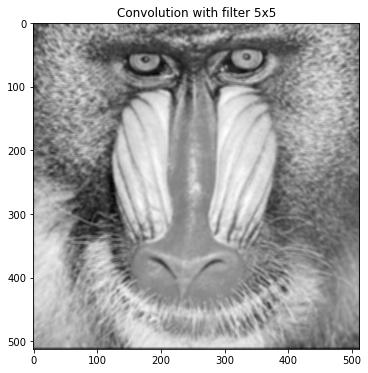

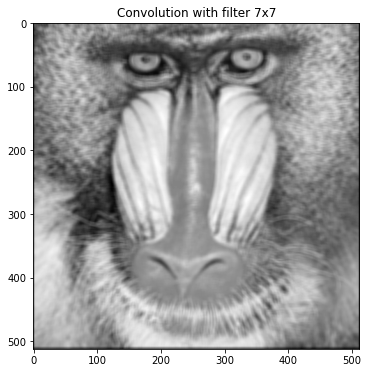

In [13]:
h3 = np.ones((3,3))*(1/9)  
conv_Mandrill3 = conv2(mandrill, h3)
imshow(conv_Mandrill3, 'Convolution with filter 3x3')

h5 = np.ones((5,5))*(1/25)  
conv_Mandrill5 = conv2(mandrill, h5)
imshow(conv_Mandrill5, 'Convolution with filter 5x5')

h7 = np.ones((7,7))*(1/49)  
conv_Mandrill7 = conv2(mandrill, h7)
imshow(conv_Mandrill7, 'Convolution with filter 7x7')

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


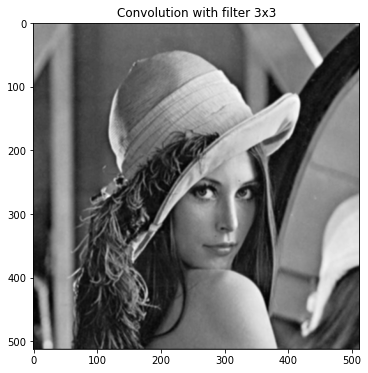

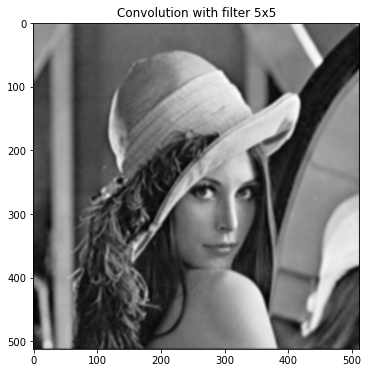

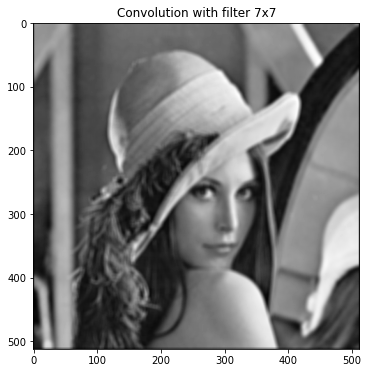

In [14]:
h3 = np.ones((3,3))*(1/9)  
print(h3)
conv_Lena3 = conv2(lena, h3)
imshow(conv_Lena3, 'Convolution with filter 3x3')

h5 = np.ones((5,5))*(1/25)  
conv_Lena5 = conv2(lena, h5)
imshow(conv_Lena5, 'Convolution with filter 5x5')

h7 = np.ones((7,7))*(1/49)  
conv_Lena7 = conv2(lena, h7)
imshow(conv_Lena7, 'Convolution with filter 7x7')

As the kernel grows, the images get more attenuated.
There is also a noticeable black border that appears around the image and that is because of the zero padding.


5. Display the transfert function of these mean filters. For a better visualization, use the zero-padding technique to obtain a filter with a large size (for instance $256\times 256$). Use `imshow()` and `toVisualizeLogFT()`.

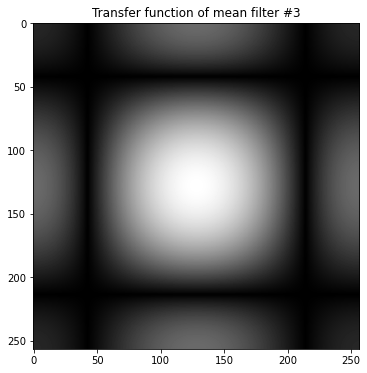

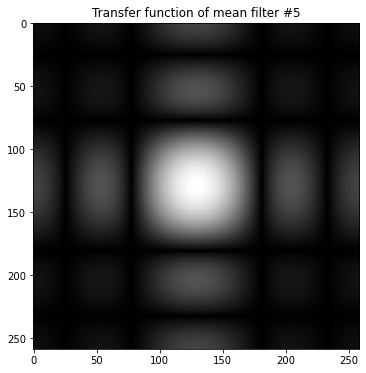

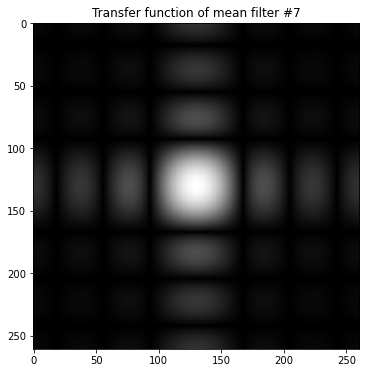

In [15]:
placeholder = np.zeros((256,256))
h3 = imagePad(h3, placeholder)
fth3 = computeFT(h3)
fth3 = toVisualizeLogFT(fth3)
imshow(fth3, "Transfer function of mean filter #3")

h5 = imagePad(h5, placeholder)
fth5 = computeFT(h5)
fth5 = toVisualizeLogFT(fth5)
imshow(fth5, "Transfer function of mean filter #5")

h7 = imagePad(h7, placeholder)
fth7 = computeFT(h7)
fth7 = toVisualizeLogFT(fth7)
imshow(fth7, "Transfer function of mean filter #7")

6. Interpretation: what is the analytic expression of the transfert function of a mean filter? Is  it an ideal low pass filter?

The transfer function of a mean filter is a periodic sinc function.

It is not an ideal low pass filter. It's a low pass filter of a bad quality but it's one of the fastest to compute.


7. Bonus question: perform the same study for the Gaussian kernel. Determine $\sigma$ in order to have filter of size $3\times3$, $5\times5$, and $7\times7$.

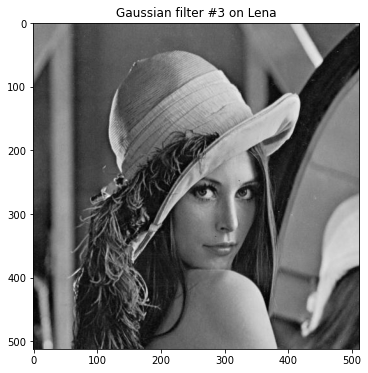

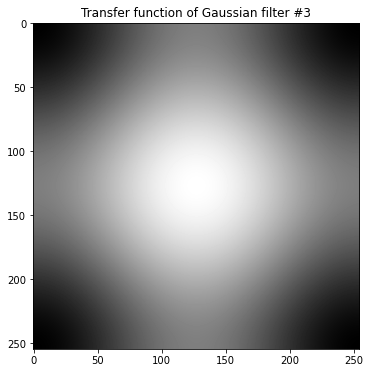

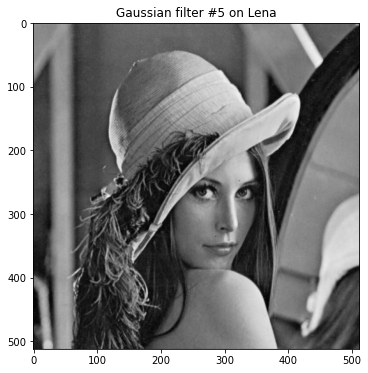

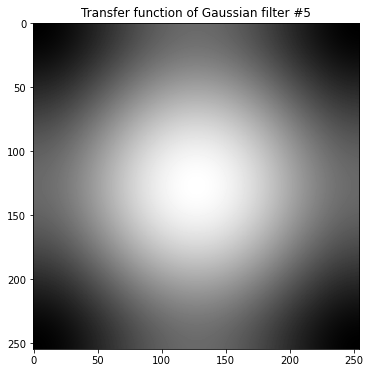

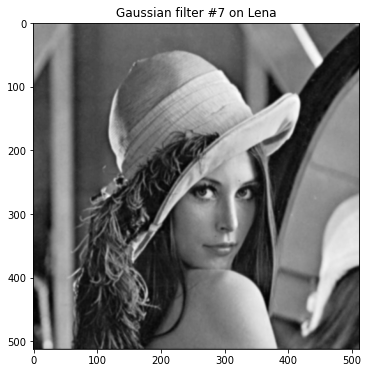

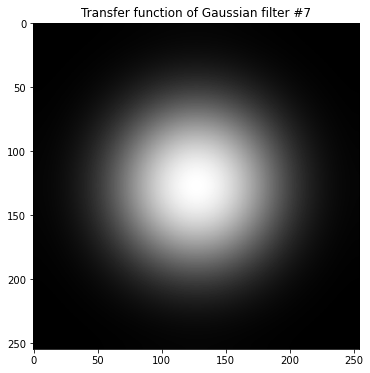

In [16]:
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()
### your answer start below
# Gaussian kernel of size 3
gaussian3 = gaussianKernel(1/3)
convolvedG3 = conv2(lena,gaussian3)
imshow(convolvedG3, "Gaussian filter #3 on Lena")
# visualisation
gaussian3 = np.pad(gaussian3,int((256-gaussian3.shape[0])/2),'constant')
ftg3 = computeFT(gaussian3)
ftg3 = toVisualizeLogFT(ftg3)
imshow(ftg3, "Transfer function of Gaussian filter #3")

# Gaussian kernel of size 5
gaussian5 = gaussianKernel(0.5)
convolvedG5 = conv2(lena,gaussian5)
imshow(convolvedG5, "Gaussian filter #5 on Lena")
# visualisation
gaussian5 = np.pad(gaussian5,int((256-gaussian5.shape[0])/2),'constant')
ftg5 = computeFT(gaussian5)
ftg5 = toVisualizeLogFT(ftg5)
imshow(ftg5, "Transfer function of Gaussian filter #5")

# Gaussian kernel of size 7
gaussian7 = gaussianKernel(1)
convolvedG7 = conv2(lena,gaussian7)
imshow(convolvedG7, "Gaussian filter #7 on Lena")
# visualisation
gaussian7 = np.pad(gaussian7,int((256-gaussian7.shape[0])/2),'constant')
ftg7 = computeFT(gaussian7)
ftg7 = toVisualizeLogFT(ftg7)
imshow(ftg7, "Transfer function of Gaussian filter #7")






As compared to the mean filters, the smoothing effect is slower with a Gaussian kernel.

The transfer function shows it : the effects of Gaussian filters on images are less intense, in the sense that the frequencies kept are spread more widely across the domain. They are not concentrated in that "cross" shape we have been noticing on the mean filters.

## Exercice 3: anti aliasing filtering

1. Give a code that subsamples of factor 2 (use function `subSample2()` given in TME3) the image `img/barbara.png`.

In [17]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

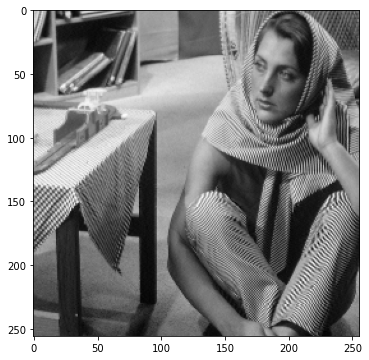

In [18]:
barbara = np.array(Image.open('img/barbara.png'))
barbara_SS2 = subSample2(barbara)
imshow(barbara_SS2)

2. Give a code that subsamples of factor 2 (use function `subSample2()`) the image `img/barbara.png` after applying an low pass filter (use `antiAliasingFilter()`). As comment, recall the principle of filtering in the frequency domain.

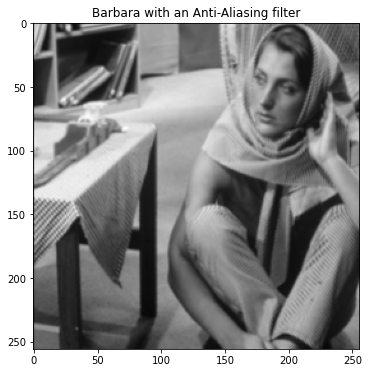

In [19]:
def antiAliasingFilter(n,m):
    """ int*int -> Array """
    n2, m2 = n//2, m//2
    rn, rm = n//4, m//4
    A = np.zeros((n, m))
    A[rn:rn+n2, rm:rm+m2] = 1
    return A
### your answer start below

#anti_Aliasing_Filter = antiAliasingFilter(64,64)
#anti_Aliasing_Filter = antiAliasingFilter(32,32)
#anti_Aliasing_Filter = antiAliasingFilter(16,16)
anti_Aliasing_Filter = antiAliasingFilter(8,8)

conv_AA_Barbara = conv2(barbara, anti_Aliasing_Filter)
AA_Barbara_SS2 = subSample2(conv_AA_Barbara)
imshow(AA_Barbara_SS2, 'Barbara with an Anti-Aliasing filter')

The principle of filtering in the frequency domain: 
Applying a filter in the frequency domain means zeroing all frequency components above or below a cut-off frequency ( depends if it's a high or low pass filter ).

3. Describe and analyze the filtering of Barbara with and without the anti aliasing filter. What information is lost for the two filtered images ?

In both cases, the high frequencies are lost - the texture of the lady's trousers, the texture of the napkin.

On the first case, the culprit is aliasing. The highest frequencies could not be reconstructed and got translated into a very annoying "psychedelic" pattern that hinders the reading of the image.

On the second case, we voluntarily let go of said high frequencies (by applying a low-pass filter) to prevent that pattern from appearing. It is a compromise that makes the sampled image look more "natural", although it does not really match the original.


## Exercice 4: color image
1. Read images `img/clown.bmp` and `img/clown_lumi.bmp` as two arrays named $I_1$ and $I_2$. Display these images examine their shape. What difference there are between them?

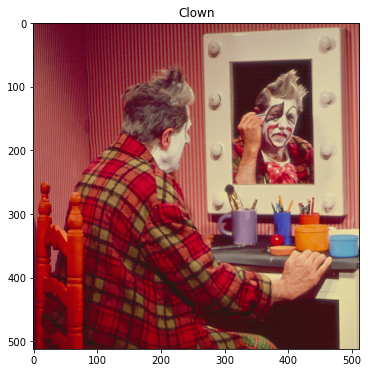

Clown Shape:  (512, 512, 3)


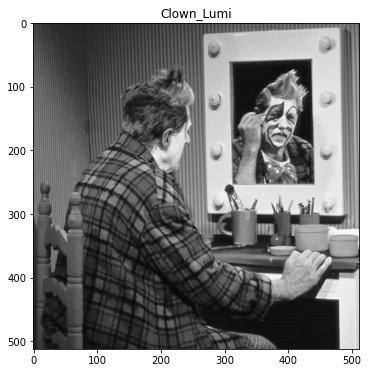

Clown_Lumi Shape:  (512, 512)


In [20]:
#This exercise will not be fun for people who have clown-phobia such as myself T_T

clown = np.array(Image.open('img/clown.bmp'))
clown_lumi = np.array(Image.open('img/clown_lumi.bmp'))

I1 = clown.copy()
I2 = clown_lumi.copy()

imshow(I1, 'Clown')
print('Clown Shape: ', I1.shape)
imshow(I2, 'Clown_Lumi')
print('Clown_Lumi Shape: ', I2.shape)


The Clown image has three channels that represent its red, green and blue channels.

And he other is a version of the clown image that shows the mean of these three values for each pixel.

Which makes us deduce that a greyscaled image is just an image with each pixel averaged out.

2. The first image is an array of dimension 3. Explain the signification of each dimension. From this image create 3 images $I_R$, $I_G$, $I_B$ of dimension 2. Display these three images and explain what you see.

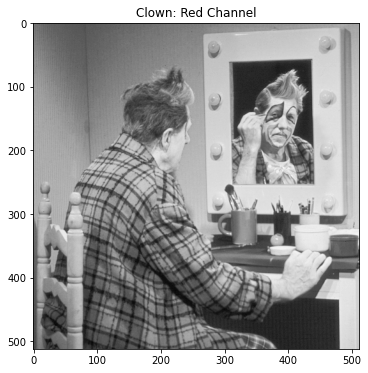

(512, 512)


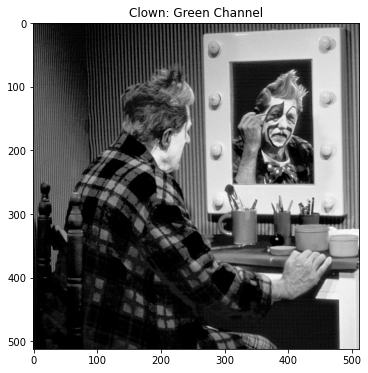

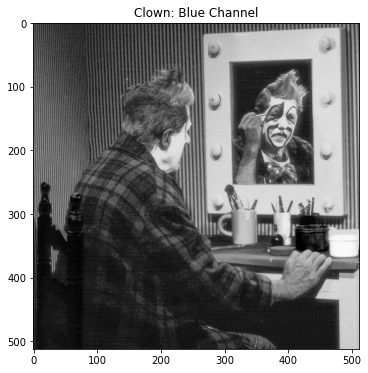

In [21]:
# isolate the red channel
Ir = I1[:,:,0] 
# isolate the green channel
Ig = I1[:,:,1] 
# isolate the blue channel
Ib = I1[:,:,2]

imshow(Ir, 'Clown: Red Channel')
print(Ir.shape)
imshow(Ig, 'Clown: Green Channel')
imshow(Ib, 'Clown: Blue Channel')

Each of these images show us the contribution of each channel to the image. We can see that the red channel image is the lighter one so we can deduce that it's the dominant channel of the 3.

3. Create a new image $I_3$ of dimensions 3, the first dimension contains the value of $I_R$, the second the value of $I_B$ and the third the values of $I_G$. Try another combinations. Remark: color images are better handled by `imshow()` if pixel values range in $[0,1]$.

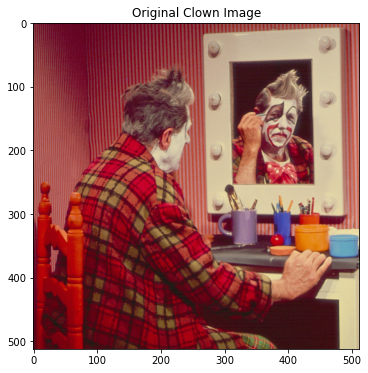

Let's get crazyyyyyyyyyyyy


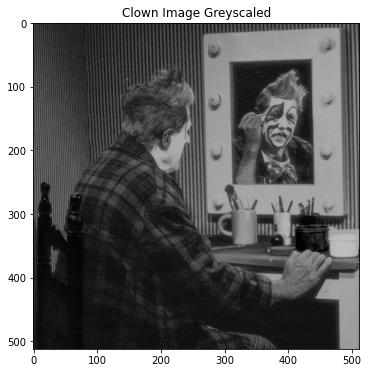

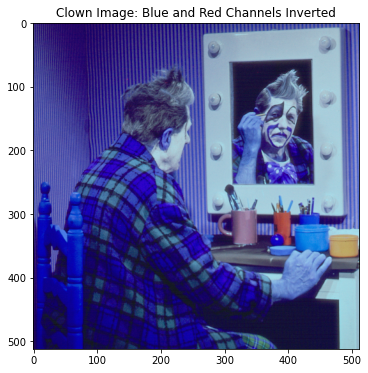

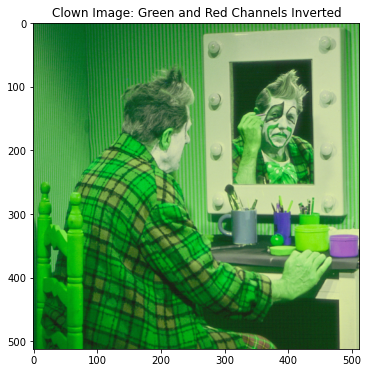

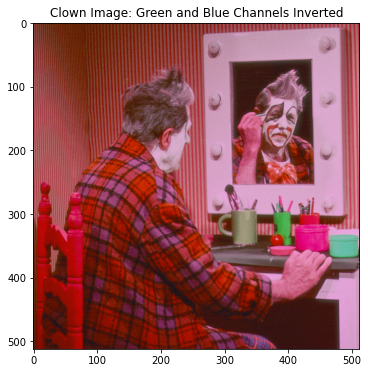

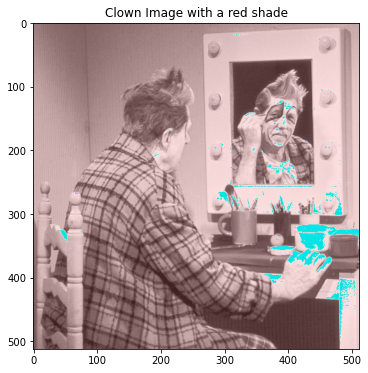

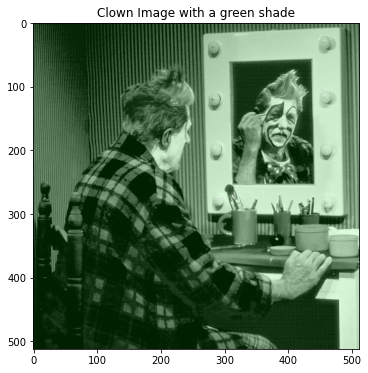

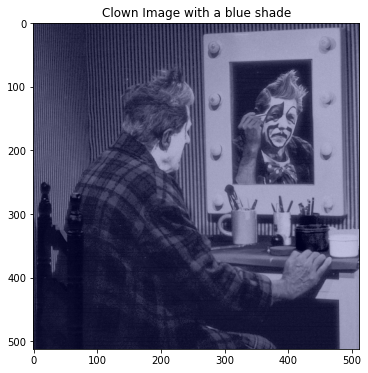

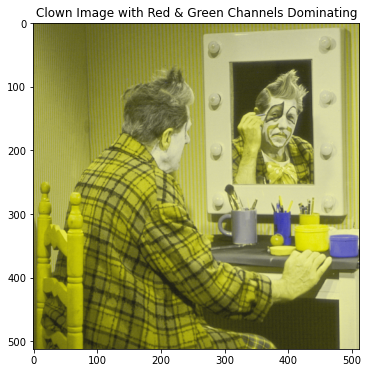

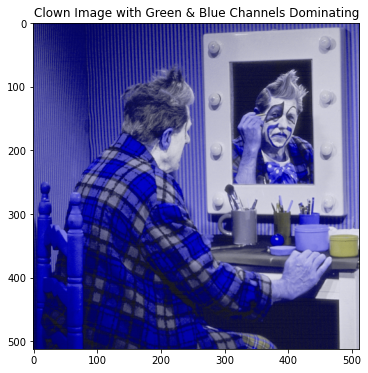

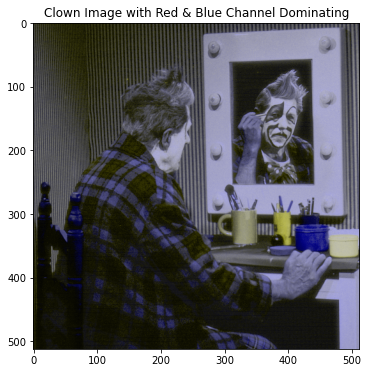

In [24]:
#We're going to use np.stack function that joins a sequence of arrays along a new axis
#Let's reproduce the original image
I3 = np.stack((Ir,Ig,Ib), axis = 2)
imshow(I3,'Original Clown Image')

print('Let\'s get crazyyyyyyyyyyyy')
#Let's reproduce the original image
#GreyScale
I3 = np.stack((Ib,Ib,Ib), axis = 2)
imshow(I3,'Clown Image Greyscaled')
#Let's invert the channels
#Inverted red and blue channels
I3 = np.stack((Ib,Ig,Ir), axis = 2)
imshow(I3,'Clown Image: Blue and Red Channels Inverted')

#Inverted green and red channels
I3 = np.stack((Ig,Ir,Ib), axis = 2)
imshow(I3,'Clown Image: Green and Red Channels Inverted')

#Inverted green and blue channels
I3 = np.stack((Ir,Ib,Ig), axis = 2)
imshow(I3,'Clown Image: Green and Blue Channels Inverted')

#Let's RED-ify the greyscaled image
I3 = np.stack((Ir+30,Ir,Ir), axis = 2)
imshow(I3,'Clown Image with a red shade')

#Let's Green-ify the greyscaled image
I3 = np.stack((Ig,Ig+30,Ig), axis = 2)
imshow(I3,'Clown Image with a green shade')

#Let's RED-ify the greyscaled image
I3 = np.stack((Ib,Ib,Ib+30), axis = 2)
imshow(I3,'Clown Image with a blue shade')

#Let's make channels dominate an other
#Dominating Red, Dominating Green, Underpowering Blue
I3 = np.stack((Ir,Ir,Ib), axis = 2)
imshow(I3,'Clown Image with Red & Green Channels Dominating')

#Underpowering Red, Dominating Green, Dominating Blue
I3 = np.stack((Ig,Ig,Ir), axis = 2)
imshow(I3,'Clown Image with Green & Blue Channels Dominating')

#Dominating Red, Underpowering Green, Dominating Blue
I3 = np.stack((Ib,Ib,Ig), axis = 2)
imshow(I3,'Clown Image with Red & Blue Channel Dominating')



4. Write a code that allows the see the first channel with red color scales, the second channel in green color scales, and the blue channel in blue color scales.

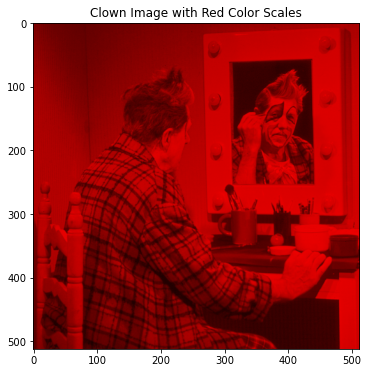

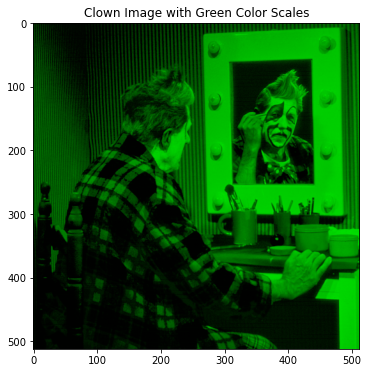

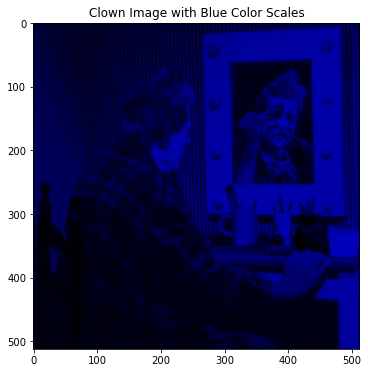

In [25]:
#To display an image with a certain color scales, we need to nullify the others channels
#And divide the result by 255 to "normalize" the image
Ir_Nullified = np.zeros(Ir.shape)
Ig_Nullified = np.zeros(Ig.shape)
Ib_Nullified = np.zeros(Ib.shape)

IrScales = np.stack((Ir, Ig_Nullified, Ib_Nullified), axis = 2)/255
IgScales = np.stack((Ir_Nullified, Ig, Ib_Nullified), axis = 2)/255
IbScales = np.stack((Ir_Nullified, Ig_Nullified, Ib), axis = 2)/255

imshow(IrScales, 'Clown Image with Red Color Scales')
imshow(IgScales, 'Clown Image with Green Color Scales')
imshow(IbScales, 'Clown Image with Blue Color Scales')
